In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hakgyunhong","key":"50913cd2335ebf13e16010fcf0c55c45"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!kaggle competitions download -c house-prices-advanced-regression-techniques
!kaggle datasets download -d fuzzywizard/movielens-100k-small-dataset

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 116MB/s]


In [4]:
!unzip movielens-100k-small-dataset.zip
!ls

Archive:  movielens-100k-small-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                
kaggle.json  movielens-100k-small-dataset.zip  ratings.csv  sample_data
links.csv    movies.csv			       README.txt   tags.csv


# Import Data

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import itertools

# Modeling helper
#from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Evaluation metrics:

# Regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score,mean_absolute_error

# Classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Deep Learning
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
#from keras.preprocessing import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno


# Config
%matplotlib inline
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context='notebook',palette='dark',style='whitegrid',color_codes=True)


In [10]:
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

## Extract Data

In [16]:
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')
df_r = ratings.copy()
df_m = movies.copy()

### Rating

In [17]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


- userId : Every user is represented by unique number
- movieId : Every movie is represented by an unique Id
- rating : Represents the rating given by the user to the corresponding movie
- timestamp : The time at which the rating was recorded

In [18]:
ratings.shape

(100836, 4)

In [19]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


### Movie

In [20]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


- moiveId : Every movie is represented by unique Id
- title : Movie which represented by the corresponding name
- genres : Represents category of movie

In [21]:
print('Shape : ',movies.shape,'\n')
movies.info()

Shape :  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


## Combine data with movieId(Common Item)

In [22]:
df_combined = pd.merge(ratings, movies, on='movieId')
#pandas merge function can combine data

In [23]:
df_combined.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [24]:
df_combined.shape

(100836, 6)

# Visualization

## Genre

In [26]:
# Create function to find genres in the dataset

genres = {}

def find_genres():
  for genre in movies['genres']:
    words = genre.split('|')
    for word in words:
      genres[word]=genres.get(word,0)+1
      # is this count

find_genres()

In [27]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [28]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

### Genre WordCloud

In [29]:
from wordcloud import WordCloud

In [30]:
wordcloud = WordCloud(width=400,height=200,background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

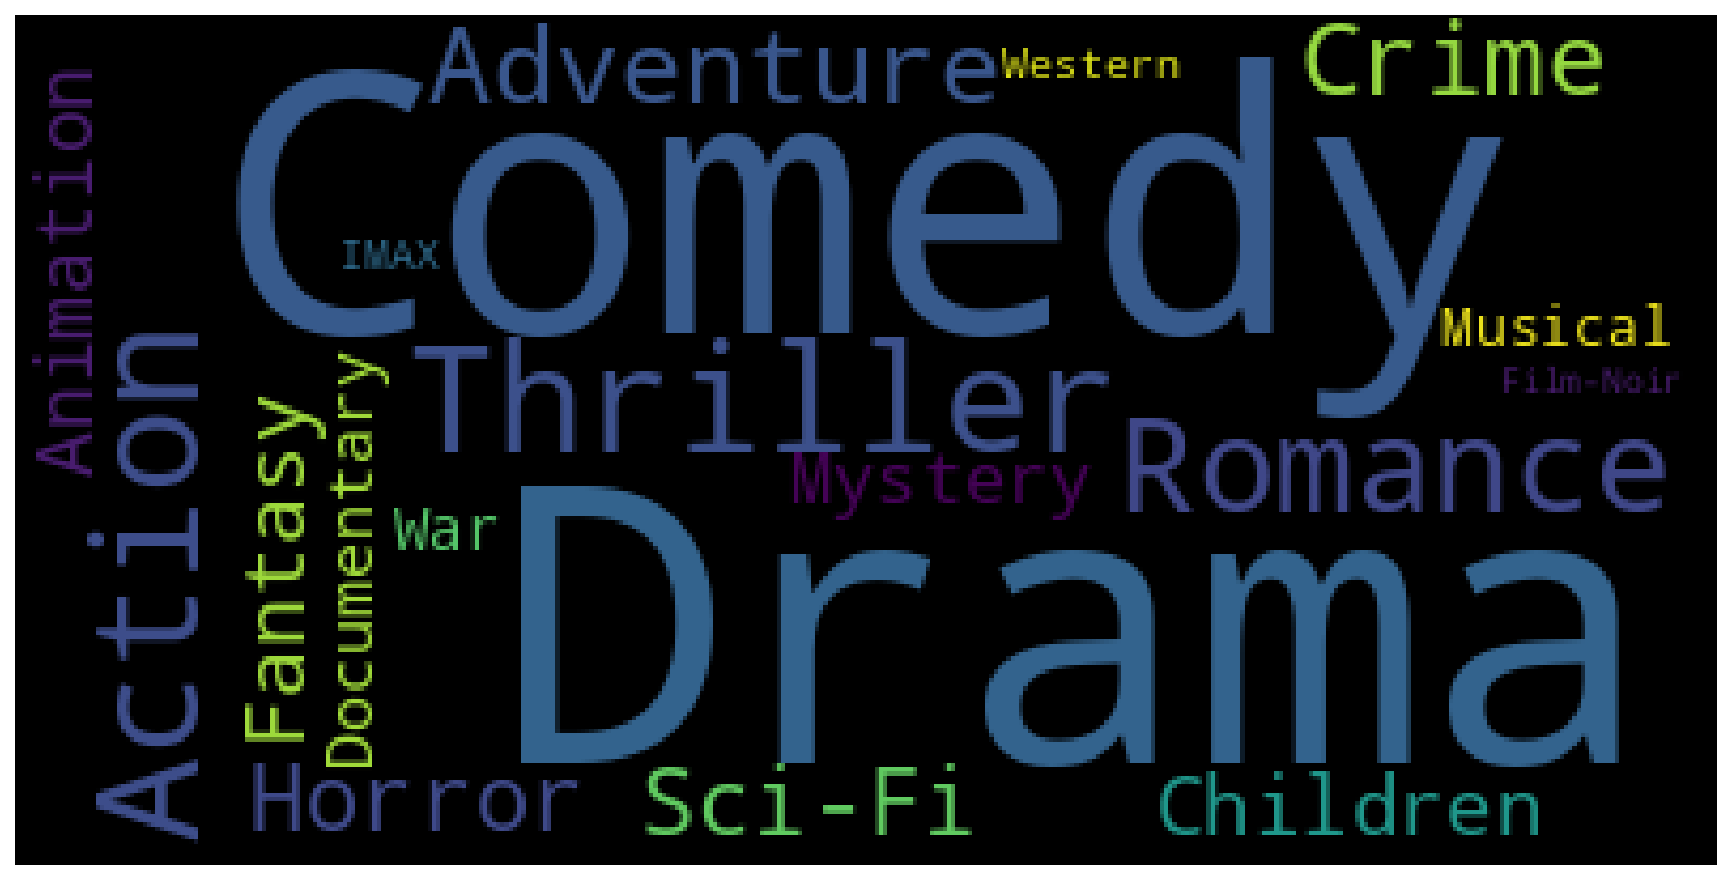

In [31]:
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Heavily Rated Movies

In [32]:
df_n_ratings=pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings']=pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns={'rating':'mean ratings'}, inplace=True)
df_n_ratings.sort_values('total ratings',ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


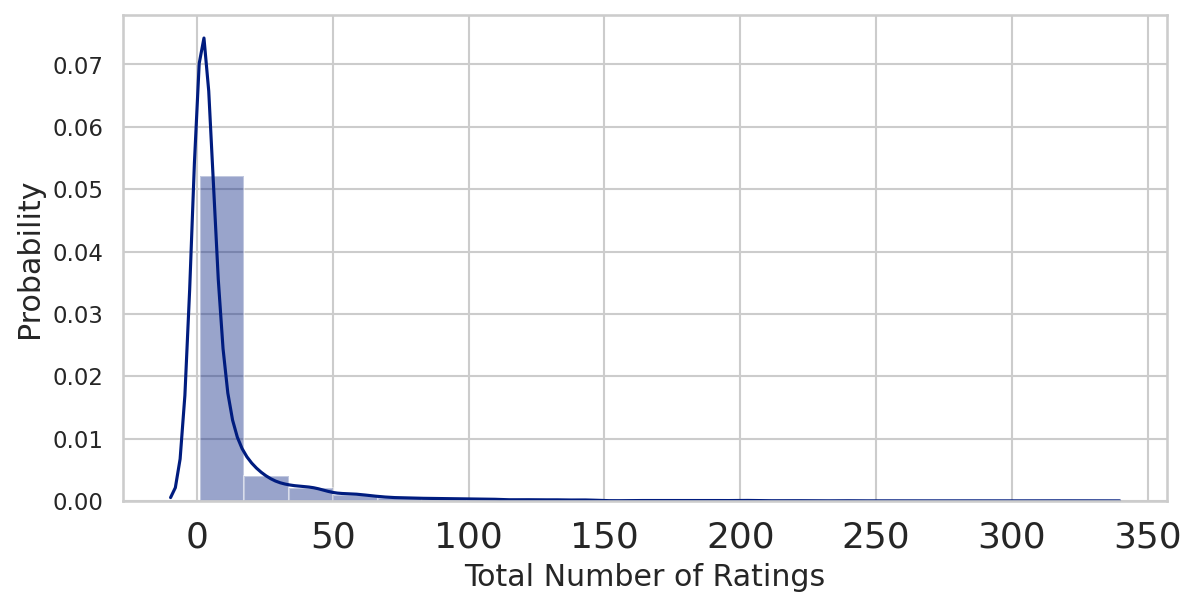

In [33]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'],bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

- Majority of movies have less than 50 ratings
- The number of movies have more than 50 ratings is very low

## Highly Rated Movie

In [35]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [36]:
print('Total No of users that gave rating of 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings']==5]),'\n')
print('Total No of Individual users that gave rating of 5.0 : ',len(df_n_ratings.loc[(df_n_ratings['mean ratings']==5) &(df_n_ratings['total ratings']==1)]))

Total No of users that gave rating of 5.0 :  296 

Total No of Individual users that gave rating of 5.0 :  289


In [37]:
df_n_ratings.loc[df_n_ratings['mean ratings']==5]

,mean ratings,total ratings
title,,
'Salem's Lot (2004),5.0,1
12 Angry Men (1997),5.0,1
12 Chairs (1976),5.0,1
20 Million Miles to Earth (1957),5.0,1
61* (2001),5.0,1
...,...,...
Won't You Be My Neighbor? (2018),5.0,1
Wonder Woman (2009),5.0,1
World of Glory (1991),5.0,1


- As you can see there are over 296 users that have rated 5 stars, among which there are 289 individual raters ( only user to rate the movie 5 star ).

- So, this cannot be the lone factor that should be considered while recommending movies. As this factor only shows the preferences of a particular user.

- It would make a good recommendation system if we can use both the factors ( -> Highly Rated Movies and Heavily Rated Movies <- ) together.

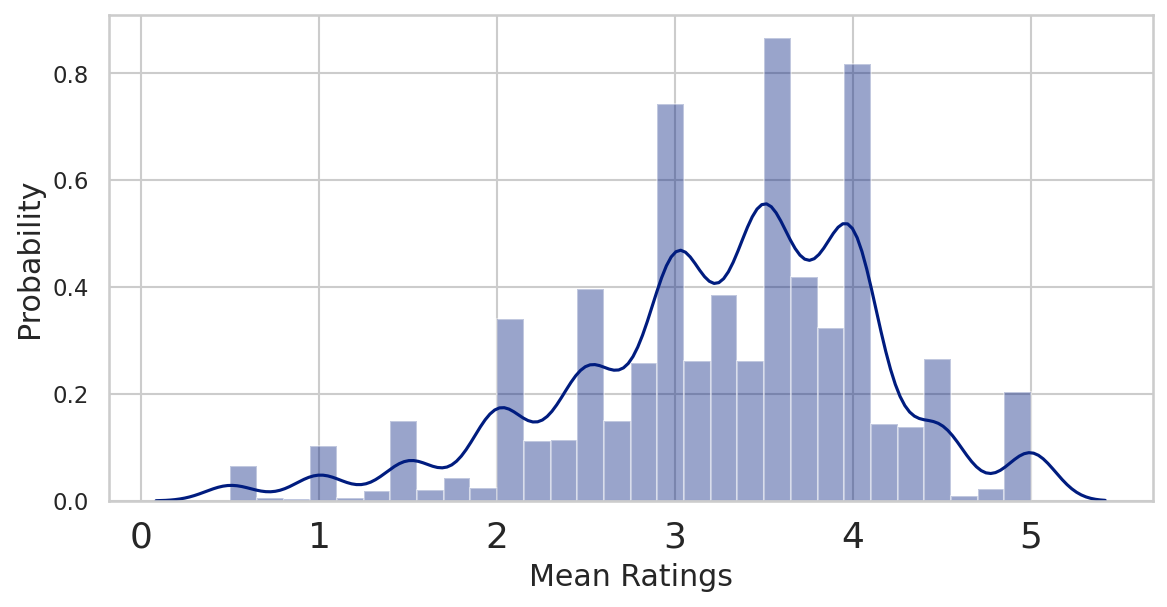

In [38]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'],bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

## Mean Ratings vs Total Number of Ratings

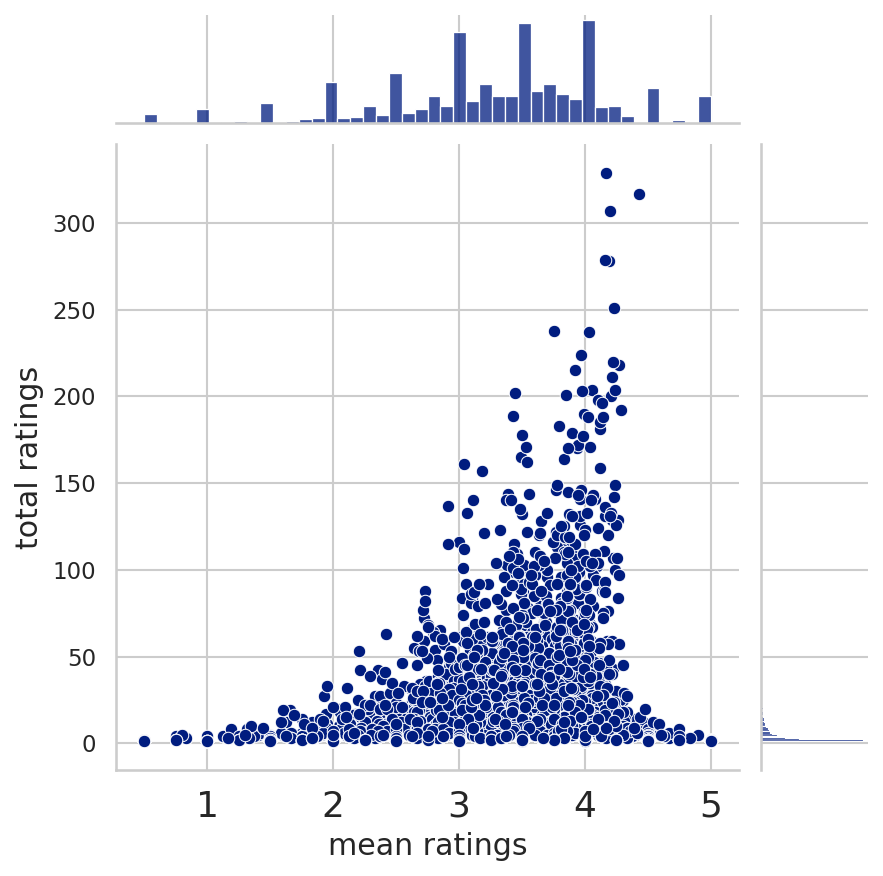

In [39]:
sns.jointplot(x='mean ratings', y='total ratings',data=df_n_ratings)

- Here, as you can see every Data Point represents a distinct Movie, with y-coordinate representing the total no of users which has rated that movie and x-coordinate representing the mean of all the ratings of the corresponding users.
- Also you can see that there is a huge Density in the region corresponding to 0-50 no of users and between mean rating 3-4 .

# Matrix Factorization using Deep Learning(Keras)

In [40]:
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

## Splitting Data into Train and Validation Set

In [41]:
X=ratings.iloc[:,:2]
Y=ratings.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=66)

In [50]:
X.head(5)

,userId,movieId
0,1,1
1,1,3
2,1,6
3,1,47
4,1,50


In [51]:
Y.head(5)

0    4.0
1    4.0
2    4.0
3    5.0
4    5.0
Name: rating, dtype: float64

For Eg. the features for the user could be ->

- How much he likes action movies?
- Whether he likes old movies?

And the features for the movies could be ->

- To what scale is it an action movie?
- Whether the movie is recently released?

And finally we take dot product which gives us the user's rating for the movie,

Estimated Rating = [ (How much he likes action movies?) x (To what scale is it an action movie) ] + [ (Whether he likes old movies?) x (Whether the movie is recently released) ]

In [42]:
n_latent_factors=50
n_users,n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique())

## Architecture 1

In [46]:
# User Embeddings
user_input = Input(shape=(1,), name ='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim = n_latent_factors, input_length=1,
                            name = 'User_Embedding')(user_input)
user_vector=Flatten(name='User_Vector')(user_embeddings)

# Movie Embeddings
movie_input=Input(shape=(1,),name='Movie_Input')
movie_embeddings=Embedding(input_dim=n_movies,output_dim=n_latent_factors, input_length=1,
                          name='Movie_Embedding')(movie_input)
movie_vector=Flatten(name='Movie_Vector')(movie_embeddings)

#Dot Product
merged_vectors = dot([user_vector,movie_vector], name='Dot_Product',axes=1)
model=Model([user_input,movie_input],merged_vectors)

# Visualizing and Model Architecture

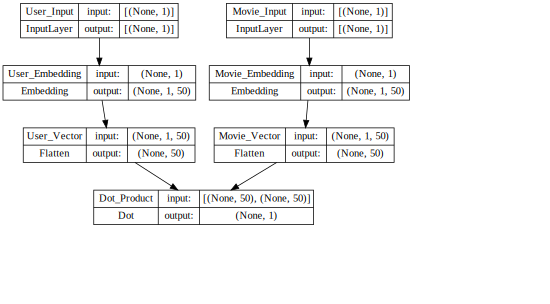

In [47]:
SVG(model_to_dot(model,show_shapes=True,show_layer_names=True).create(prog='dot', format='svg'))

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        30500       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        486200      ['Movie_Input[0][0]']            
                                                                                              

# Compile the model

In [49]:
import keras.backend as K

optimizer = Adam(lr = 0.0005)

model.compile(loss='mean_squared_error', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
batch_size = 128
epochs = 20

history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, 
                    epochs=epochs, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))